In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# here we are working on Tensorflow version 2.1.0 so we need to write tensorflow.keras.
#keras is in built function in Tensorflow.
import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image

In [3]:
train_location = "/content/drive/MyDrive/SCA/dataset"
test_location = "/content/drive/MyDrive/SCA/dataset"
filepath = '/content/drive/MyDrive/SCA/model/Sickle_VGG16_model_M1.h5'

In [4]:
#from tensorflow.keras.models import load_model
#Detection=load_model(filepath)

In [5]:
preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
img_size=224
batch_size=3
num_class=3

In [7]:
# Complete Dataset images can be loaded using ImageDataGenerator function

datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory(train_location,target_size=(img_size,img_size),batch_size=batch_size,class_mode='categorical',shuffle=True)

datagen_test=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_test.flow_from_directory(test_location,target_size=(img_size,img_size),batch_size=batch_size,class_mode='categorical',shuffle=True)


Found 756 images belonging to 3 classes.
Found 756 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [9]:
vgg = VGG16(input_shape=[img_size,img_size] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [10]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
for layer in vgg.layers:
  layer.trainable = False

In [12]:
x = Flatten()(vgg.output)
prediction = Dense(num_class, activation='softmax')(x)

In [13]:
detection = Model(inputs=vgg.input, outputs=prediction)


In [14]:
detection.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
optimum=Adam(learning_rate=0.005)
detection.compile(optimizer=optimum,loss='categorical_crossentropy',metrics=['accuracy'])



In [16]:
print(train_generator.class_indices)


{'Sickle-ISC': 0, 'normal rbc': 1, 'thaleesmia': 2}


In [17]:
TRAIN_STEPS=train_generator.n//train_generator.batch_size
TRAIN_STEPS

252

In [18]:
VALIDATION_STEPS=validation_generator.n//validation_generator.batch_size
VALIDATION_STEPS

252

In [19]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

In [21]:
callbacks_list = [checkpoint, reduce_lr]
#callbacks_list = [checkpoint]

In [22]:
#history = detection.fit_generator(train_generator,
history = detection.fit(train_generator,
                              steps_per_epoch=TRAIN_STEPS,
                              #class_weight=class_weights,
                              validation_data=validation_generator,
                              validation_steps=VALIDATION_STEPS,
                              epochs=5,
                              verbose=1,
                              callbacks=callbacks_list
                             )

Epoch 1/5
252/252 [==============================] - ETA: 0s - loss: 32.9762 - accuracy: 0.8228
Epoch 1: val_accuracy improved from -inf to 0.88228, saving model to /content/drive/MyDrive/SCA/model/Sickle_VGG16_model_M1.h5
252/252 [==============================] - 271s 1s/step - loss: 32.9762 - accuracy: 0.8228 - val_loss: 39.4610 - val_accuracy: 0.8823 - lr: 0.0050
Epoch 2/5
250/252 [============================>.] - ETA: 0s - loss: 20.1362 - accuracy: 0.9080
Epoch 2: val_accuracy improved from 0.88228 to 0.97090, saving model to /content/drive/MyDrive/SCA/model/Sickle_VGG16_model_M1.h5
252/252 [==============================] - 11s 42ms/step - loss: 20.8210 - accuracy: 0.9074 - val_loss: 7.0471 - val_accuracy: 0.9709 - lr: 0.0050
Epoch 3/5
252/252 [==============================] - ETA: 0s - loss: 7.0656 - accuracy: 0.9722
Epoch 3: val_accuracy did not improve from 0.97090
252/252 [==============================] - 11s 42ms/step - loss: 7.0656 - accuracy: 0.9722 - val_loss: 7.1786 -

In [23]:
# get the metric names so I can use evaulate_generator
detection.metrics_names

['loss', 'accuracy']

In [24]:
# here the the last epoch will be used.

detection.evaluate_generator(validation_generator,steps=TRAIN_STEPS)

<ipython-input-24-b7cdd0bfccbf>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  detection.evaluate_generator(validation_generator,steps=TRAIN_STEPS)


[1.036417841911316, 0.9920634627342224]

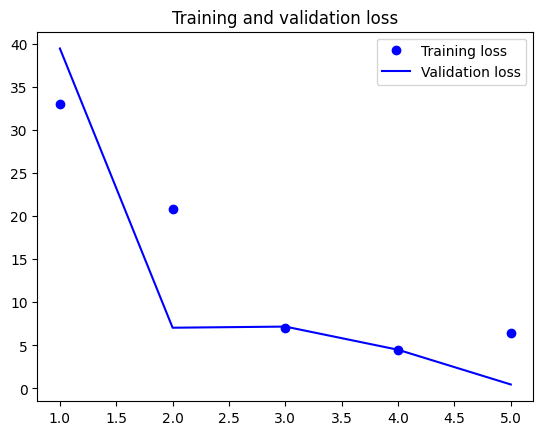

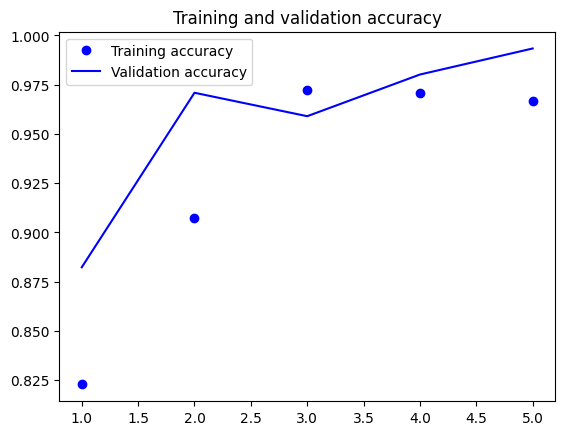

<Figure size 640x480 with 0 Axes>

In [25]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [26]:
epochs

range(1, 6)

In [27]:
loss

[32.976219177246094,
 20.821033477783203,
 7.065607070922852,
 4.4968485832214355,
 6.391803741455078]

In [28]:
val_loss

[39.461002349853516,
 7.0470662117004395,
 7.178597927093506,
 4.489891052246094,
 0.45929500460624695]

In [29]:
acc

[0.8227513432502747,
 0.9074074029922485,
 0.9722222089767456,
 0.9708994626998901,
 0.9669312238693237]

In [30]:
val_acc

[0.8822751045227051,
 0.9708994626998901,
 0.9589946866035461,
 0.9801587462425232,
 0.9933862686157227]